# Supervised Topic Modeling with Tomotopy

Outline:
- 1) Supervised LDA (sLDA) with Tomotopy
- 2) Data Preparation
- 3) Model Training & Evaluation
- 4) Topic Extraction & Analysis

This notebook implements supervised LDA using the tomotopy package, which incorporates response variables (IPI data) directly in the topic modeling process, allowing the model to learn topics that are correlated with the numeric outcomes (IPI values).

## 1) Supervised LDA (sLDA) Implementation with Tomotopy

Unlike the previous approach that used a two-stage method (sklearn LDA + Linear Regression), we'll implement true supervised LDA using tomotopy, which integrates the supervision signal (IPI data) directly into the topic modeling process.

In [50]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import tomotopy as tp  # We're using tomotopy for supervised LDA
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## 2) Data Preparation

Let's load the pre-processed newspaper data and the IPI (supervision) data for sLDA modeling.

In [54]:
# Load publishers information
publishers = pd.read_csv("../data/processed/publishers.csv")
print(f"Loaded information for {len(publishers)} publishers")

# Load all samples from processed newspapers folder
# Create a function to convert publisher names to filenames
def publisher_to_filename(publisher_name):
    # Replace special characters with underscores
    return f"sample_{re.sub(r'\W+', '_', publisher_name.lower()).strip('_')}.csv"

# Load all sample files
df_all = pd.concat([
    pd.read_csv(f"../data/processed/newspapers/{publisher_to_filename(pub)}")
    for pub in publishers['publication']
], ignore_index=True)

print(f"Loaded {len(df_all)} newspaper articles")
print(f"Sample data columns: {df_all.columns.tolist()}")

# Examine the first rows to understand the data
df_all.head()

Loaded information for 26 publishers
Loaded 254701 newspaper articles
Sample data columns: ['date', 'year', 'month', 'day', 'author', 'title', 'article', 'url', 'section', 'publication']
Loaded 254701 newspaper articles
Sample data columns: ['date', 'year', 'month', 'day', 'author', 'title', 'article', 'url', 'section', 'publication']


Loaded information for 26 publishers
Loaded 254701 newspaper articles
Sample data columns: ['date', 'year', 'month', 'day', 'author', 'title', 'article', 'url', 'section', 'publication']
Loaded 254701 newspaper articles
Sample data columns: ['date', 'year', 'month', 'day', 'author', 'title', 'article', 'url', 'section', 'publication']


,date,year,month,day,author,title,article,url,section,publication
0,2018-06-13,2018,6.0,13,NaN,Volkswagen CEO says still trying to overcome d...,BERLIN (Reuters) - Volkswagen’s (VOWG_p.DE) ne...,https://www.reuters.com/article/us-volkswagen-...,Environment,Reuters
1,2018-11-09,2018,11.0,9,"Jalil Ahmad Rezayee, Storay Karimi",Displaced victims of worst Afghan drought in y...,"HERAT, Afghanistan (Reuters) - Mahiuddin, a 35...",https://www.reuters.com/article/us-afghanistan...,Environment,Reuters
2,2020-03-11,2020,3.0,11,NaN,UK announces five billion pound emergency resp...,LONDON (Reuters) - Finance minister Rishi Suna...,https://www.reuters.com/article/us-britain-bud...,Business News,Reuters
3,2016-11-02,2016,11.0,2,NaN,Fitch: No Impact on Ardshinbank's Ratings from...,(The following statement was released by the r...,http://www.reuters.com/article/idUSFit978977,Intel,Reuters
4,2019-10-15,2019,10.0,15,NaN,U.S. to push diplomacy in bid to halt Syria at...,"WASHINGTON, Oct 15 (Reuters) - The United Stat...",https://www.reuters.com/article/syria-security...,Market News,Reuters


In [ ]:
# Load IPI (response variable) data - this is monthly data that we'll use for supervision
df_ipi = pd.read_csv("../data/processed/ipi_data.csv")

# Display the IPI data
print(f"Loaded IPI data with {len(df_ipi)} records")
print("Columns in df_ipi:", df_ipi.columns.tolist())
df_ipi.head()

Loaded IPI data with 3432 records
Columns in df_ipi: ['month', 'publication', 'ipi_value']


,month,publication,ipi_value
0,2010-01,Reuters,89.1897
1,2010-01,The New York Times,89.1897
2,2010-01,CNBC,89.1897
3,2010-01,The Hill,89.1897
4,2010-01,People,89.1897


### Merge newspaper data with IPI data

Since IPI data is monthly while newspaper text is at article level, we need to merge them to assign the monthly IPI values to each article in the corresponding month and publication. The newspaper data uses YYYY-MM-DD format for dates while the IPI data uses YYYY-MM format.

In [78]:
# Create month_key in df_all to match df_ipi format
# Remove time component if present and convert to month_key
df_all['month_key'] = pd.to_datetime(df_all['date'].str.split().str[0]).dt.strftime('%Y-%m')

# Merge the dataframes on month_key and publication
df_merged = pd.merge(
    df_all, 
    df_ipi[['month', 'publication', 'ipi_value']], 
left_on=['month_key', 'publication'],
    right_on=['month', 'publication']
)

# Consolidate 'month' column:
# If 'month_y' (from df_ipi) exists, rename it to 'month'.
# If 'month_x' (from df_all) also exists, it's likely redundant with 'month_key' or not the IPI-aligned month, so drop it.
if 'month_y' in df_merged.columns:
    df_merged.rename(columns={'month_y': 'month'}, inplace=True)
    if 'month_x' in df_merged.columns:
        df_merged.drop(columns=['month_x'], inplace=True, errors='ignore')
elif 'month' not in df_merged.columns:
    # This case should ideally not happen if the merge is successful and df_ipi has 'month'
    print("Warning: 'month' column is missing after merge and suffix handling.")


print("Columns in df_merged after merge and rename:", df_merged.columns.tolist())

print(f"Merged data shape: {df_merged.shape}")
print("\nSample of merged data:")
print(df_merged[['date', 'publication', 'month_key', 'ipi_value']].head())


Columns in df_merged after merge and rename: ['date', 'year', 'day', 'author', 'title', 'article', 'url', 'section', 'publication', 'month_key', 'month', 'ipi_value']
Merged data shape: (254701, 12)

Sample of merged data:
         date publication month_key  ipi_value
0  2018-06-13     Reuters   2018-06   103.2256
1  2018-11-09     Reuters   2018-11   104.0126
2  2020-03-11     Reuters   2020-03    97.6060
3  2016-11-02     Reuters   2016-11    98.3443
4  2019-10-15     Reuters   2019-10   101.5878


## 3) Model Training & Evaluation

Now we'll implement supervised LDA using tomotopy's SLDAModel, which directly incorporates the IPI values during topic inference. The `vars` parameter in SLDAModel specifies that we have one continuous response variable (the normalized IPI value).

In [65]:
# Define number of topics
num_topics = 10

# Step 1: Text preprocessing for tomotopy
print("Preprocessing text data...")

# Check if 'article' or 'content' column exists
text_column = 'article' if 'article' in df_merged.columns else 'content'

# Define a list of stopwords (standard English stopwords + common newspaper words)
stopwords = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", 
                 "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 
                 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 
                 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 
                 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 
                 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 
                 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 
                 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
                 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 
                 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 
                 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 
                 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 
                 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 
                 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 
                 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', 
                 "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 
                 'wouldn', "wouldn't", 'said', 'mr', 'also'])

# Tokenization function for tomotopy
def preprocess_text(text):
    # Keep words with 3 or more alphabetic characters
    tokens = re.findall(r'\b[a-z]{3,}\b', str(text).lower())
    return [t for t in tokens if t not in stopwords]

# Apply preprocessing to get tokenized documents
docs_tokens = df_merged[text_column].apply(preprocess_text).tolist()

# Get the IPI values as supervision labels
ipi_values = df_merged['ipi_value'].tolist()

# Normalize IPI values to smaller range for better numerical stability
# Scale to 0-1 range which works better with tomotopy
ipi_min = min(ipi_values)
ipi_max = max(ipi_values)
ipi_values_norm = [(val - ipi_min) / (ipi_max - ipi_min) for val in ipi_values]
print(f"Normalized IPI values range: {min(ipi_values_norm)} to {max(ipi_values_norm)}")

# After tokenization: check how many documents have tokens
num_docs_with_tokens = sum(1 for tokens in docs_tokens if tokens)
print(f"Documents with tokens: {num_docs_with_tokens} / {len(docs_tokens)}")
print("Sample tokenized docs:", docs_tokens[:5])


# Step 2: Initialize and train the supervised LDA model
print(f"Training sLDA model with {num_topics} topics...")

# Initialize the sLDA model with hyperparameters
# For the 'vars' parameter in tomotopy:
# - 1: Use the value 1 for continuous variables
# - Integer > 1: Number of categories for categorical variables
slda_model = tp.SLDAModel(
    k=num_topics,  # Number of topics
    alpha=0.1,     # Prior document-topic density
    eta=0.01,      # Prior topic-word density
    seed=42,       # For reproducibility
    vars=['l']       # One continuous regression variable (the IPI value) - Reverted to 'l'
)

# Add documents with their corresponding labels (IPI values)
for i, (tokens, ipi) in enumerate(zip(docs_tokens, ipi_values_norm)):
    if tokens:  # Ensure document has tokens after preprocessing
        slda_model.add_doc(tokens, [float(ipi)])  # tomotopy expects label as a list, ensure float type

# After adding documents: check the number of documents in the model
print(f"Number of documents in sLDA model: {len(slda_model.docs)}")
assert len(slda_model.docs) > 0, "No documents were added to the sLDA model!"

# Train the model
print("Training sLDA model...")
for i in range(0, 100, 10):
    slda_model.train(10)  # Train 10 iterations at a time
    print(f'Iteration: {i+10}\tLog-likelihood: {slda_model.ll_per_word}')

print("sLDA model training complete")

# Evaluate the model's predictive performance - tomotopy will give us regression coefficients
raw_coef_output = slda_model.get_regression_coef() # Expected: [[c0, c1, ..., c_N-1]] or [c0, ..., c_N-1]

# Correctly extract 1D list of coefficients
if isinstance(raw_coef_output, (list, np.ndarray)) and \
   len(raw_coef_output) == 1 and \
   isinstance(raw_coef_output[0], (list, np.ndarray)) and \
   all(isinstance(c, (int, float, np.number)) for c in raw_coef_output[0]):
    # Handles [[c0, c1, ..., cN-1]]
    coefficients_1d = [float(c) for c in raw_coef_output[0]]
elif isinstance(raw_coef_output, (list, np.ndarray)) and \
     all(isinstance(c, (int, float, np.number)) for c in raw_coef_output):
    # Handles [c0, c1, ..., cN-1] (already 1D)
    coefficients_1d = [float(c) for c in raw_coef_output]
else:
    print(f"Warning: Unexpected format for regression coefficients. Got: {raw_coef_output}")
    coefficients_1d = [] # Fallback

# Define intercept and topic_coefs
# Assuming if len(coefficients_1d) == num_topics, all are topic_coefs and intercept is 0
# If len(coefficients_1d) == num_topics + 1, first is intercept, rest are topic_coefs
if len(coefficients_1d) == num_topics:
    intercept = 0.0
    topic_coefs = coefficients_1d
    print(f"Interpreting {len(coefficients_1d)} coefficients as all topic-specific, intercept = 0.0")
elif len(coefficients_1d) == num_topics + 1:
    intercept = coefficients_1d[0]
    topic_coefs = coefficients_1d[1:]
    print(f"Interpreting {len(coefficients_1d)} coefficients as intercept + {len(topic_coefs)} topic-specific.")
else:
    print(f"Warning: Unexpected number of coefficients ({len(coefficients_1d)}). Expected {num_topics} or {num_topics + 1}. Defaulting intercept to 0 and using all as topic_coefs if available.")
    intercept = 0.0
    topic_coefs = coefficients_1d if coefficients_1d else []


print("\nRegression coefficients (topic influence on IPI):")
print(f"Intercept: {intercept:.4f}")
print(f"Number of topic coefficients: {len(topic_coefs)} (should be {num_topics})")
if len(topic_coefs) != num_topics:
    print(f"WARNING: Number of topic coefficients ({len(topic_coefs)}) does not match num_topics ({num_topics})! Check model initialization and document addition.")
for k, coef in enumerate(topic_coefs):
    print(f"Topic {k}: {coef:.4f}")


# Get topic distributions for validation set to evaluate model performance
# For sLDA, we need to calculate predictions and compare with actual values
print("\nCalculating model predictions...")

# Get regression coefficients from sLDA model
raw_coef_output_pred = slda_model.get_regression_coef() # Renamed to avoid conflict if any subtle scope issue

# Correctly extract 1D list of coefficients for prediction
if isinstance(raw_coef_output_pred, (list, np.ndarray)) and \
   len(raw_coef_output_pred) == 1 and \
   isinstance(raw_coef_output_pred[0], (list, np.ndarray)) and \
   all(isinstance(c, (int, float, np.number)) for c in raw_coef_output_pred[0]):
    # Handles [[c0, c1, ..., cN-1]]
    coefficients_1d_pred = [float(c) for c in raw_coef_output_pred[0]]
elif isinstance(raw_coef_output_pred, (list, np.ndarray)) and \
     all(isinstance(c, (int, float, np.number)) for c in raw_coef_output_pred):
    # Handles [c0, c1, ..., cN-1] (already 1D)
    coefficients_1d_pred = [float(c) for c in raw_coef_output_pred]
else:
    print(f"Warning: Unexpected format for regression coefficients during prediction. Got: {raw_coef_output_pred}")
    coefficients_1d_pred = [] # Fallback

# Define intercept and topic_coefs for prediction (mirroring the logic above)
if len(coefficients_1d_pred) == num_topics:
    intercept_pred = 0.0
    topic_coefs_pred = coefficients_1d_pred
elif len(coefficients_1d_pred) == num_topics + 1:
    intercept_pred = coefficients_1d_pred[0]
    topic_coefs_pred = coefficients_1d_pred[1:]
else: # Fallback, should match the logic for non-pred variables
    intercept_pred = 0.0
    topic_coefs_pred = coefficients_1d_pred if coefficients_1d_pred else []

# Ensure intercept and topic_coefs used in this prediction block are the _pred versions
intercept = intercept_pred
topic_coefs = topic_coefs_pred

predicted_values = []
actual_values = []

for i, doc in enumerate(slda_model.docs):
    topic_dist = doc.get_topic_dist()
    # Ensure topic_dist is 1D and matches topic_coefs
    pred = intercept + sum(coef * prob for coef, prob in zip(topic_coefs, topic_dist))
    predicted_values.append(float(pred))
    actual = float(ipi_values_norm[i])  # Already normalized above
    actual_values.append(actual)

# Convert to 1D numpy arrays for sklearn metrics
#import numpy as np
predicted_values = np.array(predicted_values).flatten()
actual_values = np.array(actual_values).flatten()

# Calculate performance metrics
mse = mean_squared_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

print(f"Model evaluation: R² = {r2:.4f}, MSE = {mse:.4f}")

Preprocessing text data...
Normalized IPI values range: 0.0 to 1.0
Documents with tokens: 254633 / 254701
Sample tokenized docs: [['berlin', 'reuters', 'volkswagen', 'new', 'chief', 'executive', 'herbert', 'diess', 'carmaker', 'still', 'trying', 'overcome', 'emissions', 'cheating', 'scandal', 'german', 'authorities', 'ordered', 'wolfsburg', 'based', 'company', 'pay', 'billion', 'euro', 'billion', 'fine', 'volkswagen', 'takes', 'responsibility', 'diesel', 'crisis', 'diess', 'statement', 'wednesday', 'agreed', 'accept', 'fine', 'steps', 'necessary', 'restore', 'trust', 'company', 'auto', 'industry', 'reporting', 'andreas', 'cremer', 'writing', 'edward', 'taylor', 'editing', 'victoria', 'bryan'], ['herat', 'afghanistan', 'reuters', 'mahiuddin', 'year', 'old', 'farmer', 'badghis', 'mountainous', 'province', 'western', 'afghanistan', 'living', 'camp', 'outside', 'city', 'herat', 'months', 'one', 'tens', 'thousands', 'displaced', 'worst', 'drought', 'country', 'seen', 'years', 'billions', 'd

C:\Users\javerkin\AppData\Local\Temp\ipykernel_13504\1326012606.py:81: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  slda_model.train(10)  # Train 10 iterations at a time


Iteration: 10	Log-likelihood: -10.514411825771223
Iteration: 20	Log-likelihood: -9.598487203555178
Iteration: 30	Log-likelihood: -9.48718781597647
Iteration: 30	Log-likelihood: -9.48718781597647
Iteration: 40	Log-likelihood: -9.443326224942334
Iteration: 50	Log-likelihood: -9.419460711597305
Iteration: 60	Log-likelihood: -9.404841436775163
Iteration: 40	Log-likelihood: -9.443326224942334
Iteration: 50	Log-likelihood: -9.419460711597305
Iteration: 60	Log-likelihood: -9.404841436775163
Iteration: 70	Log-likelihood: -9.394863572901045
Iteration: 70	Log-likelihood: -9.394863572901045
Iteration: 80	Log-likelihood: -9.387966273049175
Iteration: 90	Log-likelihood: -9.382435462613023
Iteration: 100	Log-likelihood: -9.376530236136038
sLDA model training complete
Interpreting 10 coefficients as all topic-specific, intercept = 0.0

Regression coefficients (topic influence on IPI):
Intercept: 0.0000
Number of topic coefficients: 10 (should be 10)
Topic 0: 0.8888
Topic 1: 0.8275
Topic 2: 0.8515
Top

In [66]:
# After tokenization
num_docs_with_tokens = sum(1 for tokens in docs_tokens if tokens)
print(f"Documents with tokens: {num_docs_with_tokens} / {len(docs_tokens)}")
print("Sample tokenized docs:", docs_tokens[:5])

# After adding documents
print(f"Number of documents in sLDA model: {len(slda_model.docs)}")
assert len(slda_model.docs) > 0, "No documents were added to the sLDA model!"

Documents with tokens: 254633 / 254701
Sample tokenized docs: [['berlin', 'reuters', 'volkswagen', 'new', 'chief', 'executive', 'herbert', 'diess', 'carmaker', 'still', 'trying', 'overcome', 'emissions', 'cheating', 'scandal', 'german', 'authorities', 'ordered', 'wolfsburg', 'based', 'company', 'pay', 'billion', 'euro', 'billion', 'fine', 'volkswagen', 'takes', 'responsibility', 'diesel', 'crisis', 'diess', 'statement', 'wednesday', 'agreed', 'accept', 'fine', 'steps', 'necessary', 'restore', 'trust', 'company', 'auto', 'industry', 'reporting', 'andreas', 'cremer', 'writing', 'edward', 'taylor', 'editing', 'victoria', 'bryan'], ['herat', 'afghanistan', 'reuters', 'mahiuddin', 'year', 'old', 'farmer', 'badghis', 'mountainous', 'province', 'western', 'afghanistan', 'living', 'camp', 'outside', 'city', 'herat', 'months', 'one', 'tens', 'thousands', 'displaced', 'worst', 'drought', 'country', 'seen', 'years', 'billions', 'dollars', 'spent', 'since', 'taliban', 'ousted', 'afghanistan', 'rem

In [67]:
# Analyze the topics and regression coefficients
# Extract the top words for each topic
topic_terms = {}
for topic_idx in range(num_topics):
    # Get top 20 words for this topic
    top_terms = slda_model.get_topic_words(topic_idx, top_n=20)
    topic_weight = topic_coefs[topic_idx]  # Get regression coefficient
    topic_terms[topic_idx] = (top_terms, topic_weight)

# Print out the topics and their regression coefficients
print("\nTopic words and regression coefficients (topic influence on IPI):")
for topic_idx, (terms, weight) in topic_terms.items():
    print(f"\nTopic {topic_idx}:")
    print(f"Regression coefficient: {weight:.4f}")
    print(f"Top terms: {', '.join([term for term, _ in terms[:10]])}")
    
# Print topic weights for predicting IPI
print("\nRegression coefficients (topic influence on IPI):")
for k, coef in enumerate(topic_coefs):
    print(f"Topic {k}: {coef:.4f}")


Topic words and regression coefficients (topic influence on IPI):

Topic 0:
Regression coefficient: 0.8888
Top terms: police, aposs, told, people, court, news, law, according, year, case

Topic 1:
Regression coefficient: 0.8275
Top terms: twitter, game, year, com, first, season, star, team, new, last

Topic 2:
Regression coefficient: 0.8515
Top terms: government, country, president, would, military, china, war, united, people, north

Topic 3:
Regression coefficient: 0.8349
Top terms: company, new, facebook, like, google, apple, data, one, app, users

Topic 4:
Regression coefficient: 0.8249
Top terms: health, people, one, could, study, new, like, research, medical, water

Topic 5:
Regression coefficient: 0.8428
Top terms: company, new, million, year, city, food, uber, car, one, business

Topic 6:
Regression coefficient: 0.8480
Top terms: would, percent, year, new, companies, market, billion, money, could, million

Topic 7:
Regression coefficient: 0.8349
Top terms: trump, president, hou

### Visualize Topics

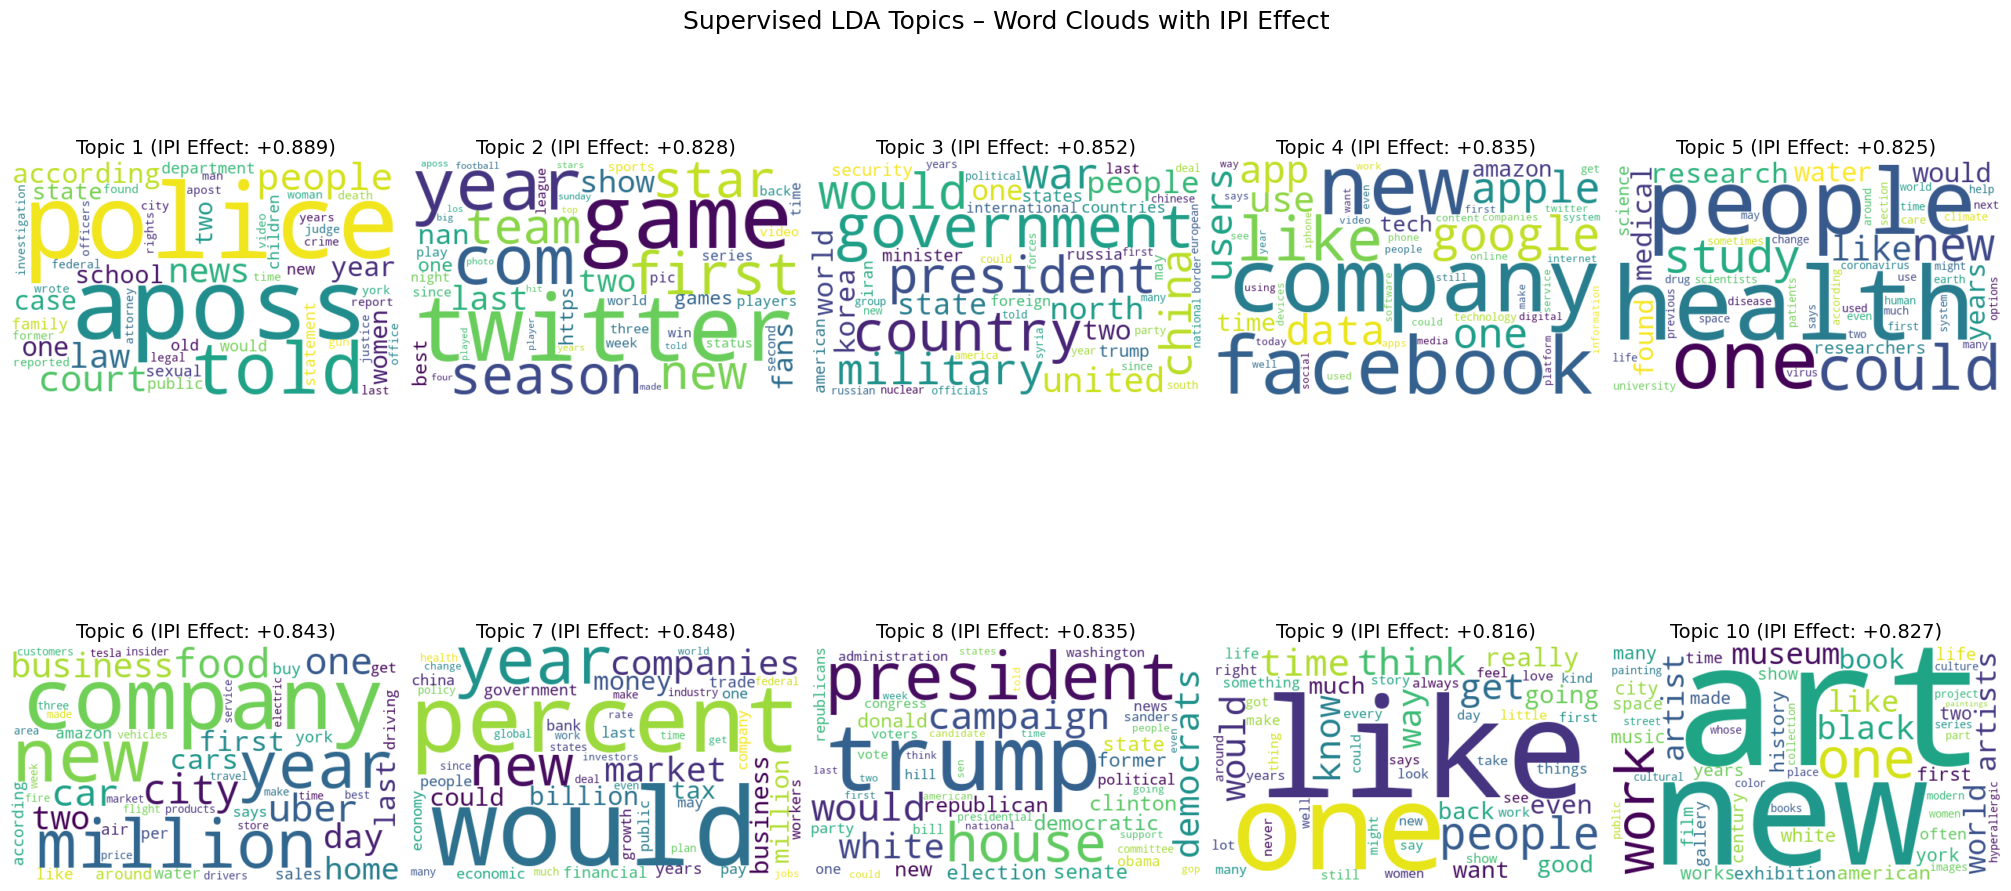

In [68]:
# Visualize the top topics and their relationship to the IPI values
fig, axes = plt.subplots(2, 5, figsize=(20, 10), constrained_layout=True)
axes = axes.flatten()

for idx, ax in enumerate(axes):
    # Get topic words and their weights
    if idx < num_topics:  # Make sure we don't exceed the number of topics
        # Get the top 50 words for this topic
        top_words = slda_model.get_topic_words(idx, top_n=50)
        
        # Create dictionary for the wordcloud
        topic_dict = {word: weight for word, weight in top_words}
        
        # Create wordcloud
        wc = WordCloud(width=500, height=300, background_color='white', max_words=50)
        wc.generate_from_frequencies(topic_dict)
        ax.imshow(wc, interpolation='bilinear')
        
        # Add title with regression coefficient to show topic-IPI relationship
        coef = topic_coefs[idx]
        coef_sign = "+" if coef > 0 else ""
        ax.set_title(f'Topic {idx + 1} (IPI Effect: {coef_sign}{coef:.3f})', fontsize=14)
        ax.axis('off')
    else:
        ax.axis('off')  # Turn off extra subplots if any

plt.suptitle('Supervised LDA Topics – Word Clouds with IPI Effect', fontsize=18)
plt.show()

In [ ]:
# Save the model
import os

# Create directory if it doesn't exist
os.makedirs("../models/topic_model", exist_ok=True)

# Save the sLDA model using tomotopy's native save method
slda_model.save("../models/topic_model/slda_model")

print("Model saved")

✅ Model saved


## 4) Topic Extraction & Analysis

In [ ]:
# Step 1: Extract document-topic distributions for each article
doc_topic_dists = []
for doc in slda_model.docs:
    doc_topic_dists.append(doc.get_topic_dist())

# Create topic column names
topic_cols = [f'topic_{i}' for i in range(num_topics)]

# Create a DataFrame with topic distributions
df_topics = pd.DataFrame(doc_topic_dists, columns=topic_cols)

# Combine with metadata
df_meta = df_merged[['date', 'publication', 'month']].reset_index(drop=True).copy()  # Using existing columns
# Only keep rows for which we have topic distributions (some might have been filtered out)
df_meta = df_meta.iloc[:len(doc_topic_dists)].copy()

df_combined = pd.concat([df_meta, df_topics], axis=1)

# Aggregate topic shares by month and publisher
df_monthly_pub = df_combined.groupby(['month', 'publication'])[topic_cols].mean().reset_index()

# Save to CSV with tomotopy_sLDA in the filename
df_monthly_pub.to_csv('../data/processed/monthly_topic_shares_by_publisher_sLDA.csv', index=False)

print("Saved: 'monthly_topic_shares_by_publisher_sLDA.csv'")

# Display the head of the saved CSV file
df_check_csv = pd.read_csv('../data/processed/monthly_topic_shares_by_publisher_sLDA.csv')
print("Head of 'monthly_topic_shares_by_publisher_sLDA.csv':")
df_check_csv.head()

✅ Saved: 'monthly_topic_shares_by_publisher_sLDA.csv'
Head of 'monthly_topic_shares_by_publisher_sLDA.csv':


,month,publication,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,2016-01,Business Insider,0.113924,0.096957,0.073923,0.136457,0.097931,0.152317,0.141147,0.012717,0.133545,0.041081
1,2016-01,CNBC,0.057679,0.044100,0.071563,0.061600,0.053359,0.114329,0.438747,0.080490,0.068683,0.009450
2,2016-01,CNN,0.135860,0.049119,0.155220,0.033329,0.082012,0.049961,0.070695,0.283742,0.108709,0.031353
3,2016-01,Economist,0.035915,0.062259,0.288431,0.050607,0.053273,0.057251,0.194292,0.060653,0.099874,0.097445
4,2016-01,Gizmodo,0.074303,0.018143,0.032679,0.324294,0.211499,0.059117,0.056758,0.042944,0.140299,0.039964


### Compare topic trends with IPI values

C:\Users\javerkin\AppData\Local\Temp\ipykernel_13504\1208111105.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(months, rotation=90)


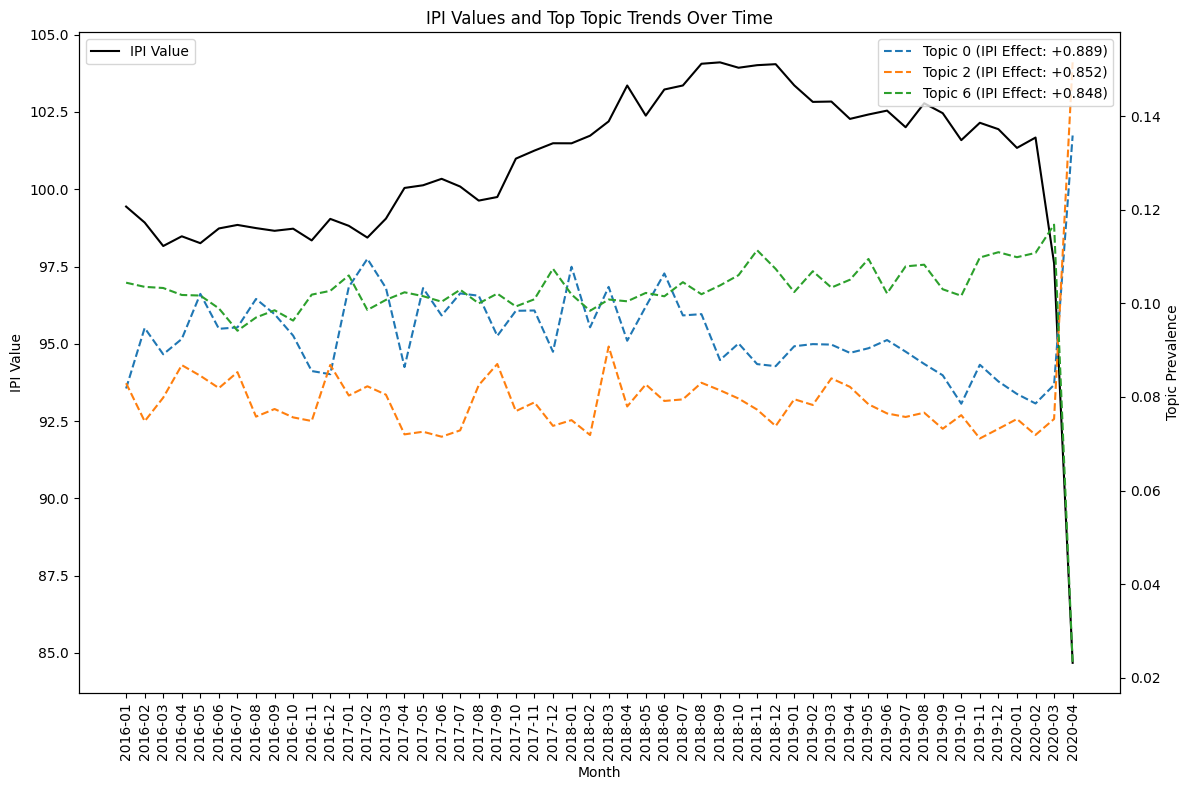

In [80]:
# Analyze the relationship between topic prevalence and IPI values

# Get average IPI by month
monthly_ipi = df_ipi.groupby('month')['ipi_value'].mean().reset_index()

# Get average topic distributions by month (across all publishers)
monthly_topics = df_monthly_pub.groupby('month')[topic_cols].mean().reset_index()

# Merge the data
df_trends = pd.merge(monthly_topics, monthly_ipi, on='month', how='inner')

# Plot the trends of the top 3 most influential topics (based on regression coefficients)
topic_importance = [(i, abs(c)) for i, c in enumerate(topic_coefs)]
top_topics = sorted(topic_importance, key=lambda x: x[1], reverse=True)[:3]

plt.figure(figsize=(12, 8))

# Plot IPI values
ax1 = plt.gca()
ax2 = ax1.twinx()

months = df_trends['month'].astype(str).tolist()
ax1.plot(months, df_trends['ipi_value'], 'k-', label='IPI Value')

# Plot topic trends
for topic_idx, importance in top_topics:
    topic_col = f'topic_{topic_idx}'
    coef = topic_coefs[topic_idx]
    coef_sign = "+" if coef > 0 else ""
    ax2.plot(months, df_trends[topic_col], '--', 
            label=f'Topic {topic_idx} (IPI Effect: {coef_sign}{coef:.3f})')

ax1.set_xlabel('Month')
ax1.set_ylabel('IPI Value')
ax2.set_ylabel('Topic Prevalence')
ax1.set_xticklabels(months, rotation=90)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('IPI Values and Top Topic Trends Over Time')
plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we implemented a true supervised LDA model using tomotopy's SLDAModel that directly incorporates IPI data as supervision during the topic modeling process. This approach is different from the previous two-stage approach which separated topic modeling and regression.

Key advantages:
- The topics are directly influenced by the IPI values during model training, not as a post-processing step
- Topics identified are more likely to be correlated with IPI movements
- Regression coefficients are built into the model, making interpretation more direct

The output CSV file (`monthly_topic_shares_by_publisher_sLDA.csv`) contains the monthly topic distributions for each publisher, which can be used for further analysis or visualization.